In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf #derin öğrenme kütüphanesi
from tensorflow.keras.preprocessing.image import ImageDataGenerator #görselleri yüklemek
from tensorflow.keras.models import Sequential#katmanları üstüste sıralı olark kullanmak
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#Conv2D->görüntüden özellik çıkarır
#MaxPooling2D → boyutu küçültür, önemli özellikleri alır.
#Flatten → 2D’den 1D’ye dönüştürür (klasik yapay sinir ağına bağlamak için).
#Dense → asıl kararların verildiği yer
#Dropout → overfitting’i engellemek için bazı nöronları rastgele kapatır.
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


2025-09-23 17:07:18.506368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758647238.849621      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758647238.942750      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = (150, 150)
batch_size = 32


In [3]:
train_datagen=ImageDataGenerator(rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            validation_split=0.2)


### Veri Önişleme

Bu aşamada modelimin daha iyi genelleme yapabilmesi için **ImageDataGenerator** kullandım:

- **Rescale:** Piksel değerlerini normalize ettim. Model bu sayede daha hızlı ve stabil öğreniyor.  
- **Rotation:** Görselleri 15 derece döndürdüm. Her MR aynı açıdan çekilmeyeceği için model farklı açılara dayanıklı hale geliyor.  
- **Width/Height Shift:** Görselleri kaydırarak tümörün farklı pozisyonlarda olmasına karşı dayanıklı hale getirdim.  
- **Shear:** Hafif perspektif kaymaları ekledim.
 * * Örneğin hastanın başı hafif eğilmiş olabilir → model sadece dik görüntülere alışırsa hata yapar.
- **Zoom:** Yakınlaştırma/uzaklaştırma ile çeşitlilik kazandırdım.  
- **Horizontal Flip:** Görseli yatay çevirerek, tümör sağda ya da solda olsa da öğrenmesini sağladım.  
- **Validation Split:** Verinin %20’sini validation için ayırdım. Böylece modelin ezberleyip ezberlemediğini kontrol edebileceğim.


In [4]:
train_generator=train_datagen.flow_from_directory(
    "/kaggle/input/brain-tumor-mri-dataset/Training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 4571 images belonging to 4 classes.


**DATASETİ ANLAMAK**

Dataset içerisinde 4 klasör var. Her klasör aslında bir etiketi temsil ediyor.
1. Glioma
 
* Beyinde görülen tümör tipi
* MRI görüntüsünde farklı bölgelerde çıkabilir.
* Model "gördüğüm resim glioma mı" diye öğrenecek 
 
2. Meningioma

*  Beyin zarından kaynaklanan tümör.
*   Görüntüsü glioma’dan farklıdır.
*   Ayrı bir sınıf olarak öğretiliyor. 

3. Pituitary
 
* Hipofiz bezi tümörü (beynin altında küçük bir bölgede). 
* MRI’da genellikle beynin ortasına yakın bir bölgede görünür.

4.  No Tumor
   * Beyinde hiç tümör yok → sağlıklı MRI görüntüsü.

* Model bu durumda “tümör yok” kararını verecek.

Bilgisayar yazıyla değil sayıyla çalışır bu yüzden **flow_from_directory** bu işlemi gerçekleştirir.
* glioma → 0
* meningioma → 1
* pituitary → 2
* no_tumor → 3

In [5]:
print("Sınıf İndeksleri\n:",train_generator.class_indices)



Sınıf İndeksleri
: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [6]:
val_generator = train_datagen.flow_from_directory(
    "/kaggle/input/brain-tumor-mri-dataset/Training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 1141 images belonging to 4 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/brain-tumor-mri-dataset/Testing",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1311 images belonging to 4 classes.


### Veri Setinin Ayrılması

- **Training Set (%80):** Modelin öğrenmesi için kullanılan veriler.  
- **Validation Set (%20):** Eğitim sırasında modelin ezberleyip ezberlemediğini kontrol etmek için kullanılan veriler.  
- **Test Set:** Eğitim tamamlandıktan sonra modelin daha önce hiç görmediği verilerle gerçek performansını ölçmek için ayrılmıştır.  

`ImageDataGenerator` içindeki `validation_split=0.2` parametresi sayesinde, Training klasöründeki veriler otomatik olarak %80 eğitim, %20 doğrulama olacak şekilde ayrıldı.  
Ayrıca Kaggle datasetinde zaten ayrı bir **Testing** klasörü bulunduğu için, final değerlendirmeyi bu veriler üzerinde yapacağız.


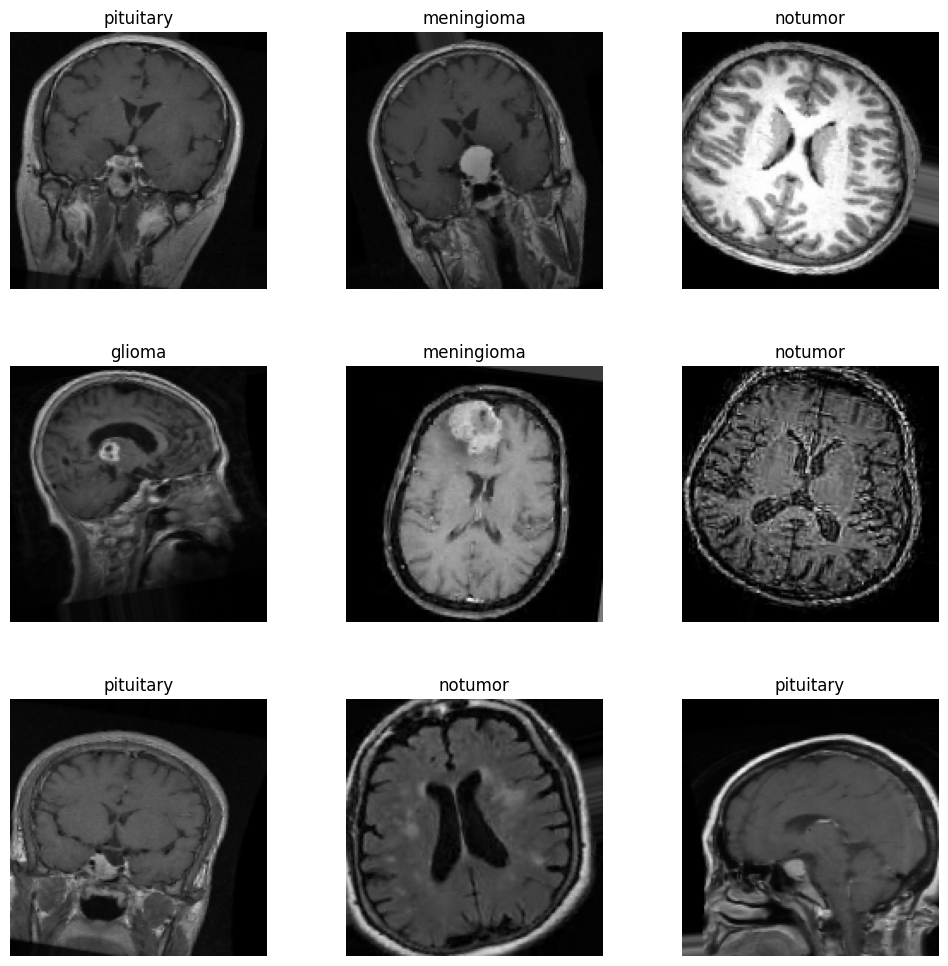

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i].astype("float32")) 
    plt.axis("off")
    
    label_index = np.argmax(y_batch[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name, fontsize=12)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  
plt.show()


📊**Eğitim Verisinden Örnek Görseller**


Bu görselleştirmede eğitim veri setinden rastgele seçilen 9 MRI görüntüsü yer almaktadır.

Görseller **ImageDataGenerator** aracılığıyla yüklendi ve 3x3 grid şeklinde gösterildi.

Her resmin üst kısmında, **flow_from_directory** tarafından otomatik atanan sınıf etiketi yazmaktadır.

Etiketler, **one-hot encoding** formatından geri dönüştürülerek okunabilir hale getirildi.

Bu görselleştirme sayesinde:

* Görsellerin doğru yüklendiğini,
* Etiketlerin klasör isimlerine göre doğru şekilde eşlendiğini,
* Her sınıftan (glioma, meningioma, pituitary, notumor) örneklerin veri setinde bulunduğunukontrol etmiş olduk.
* Bu aşama, veri ön işleme sürecinin doğrulama adımıdır. Modeli eğitmeden önce verilerin doğru geldiğinden emin olmamızı sağlar.



In [9]:
import os

train_path = "../input/brain-tumor-mri-dataset/Training"

class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

print(class_counts)


{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}


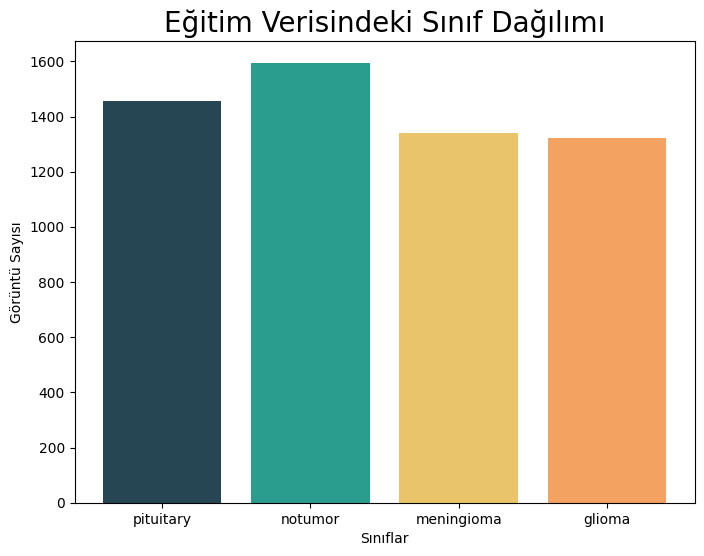

In [10]:
plt.figure(figsize=(8,6))
plt.bar(class_counts.keys(),class_counts.values(),color= [
    "#264653",  
    "#2A9D8F",  
    "#E9C46A",
    "#F4A261"   
])

plt.title("Eğitim Verisindeki Sınıf Dağılımı",fontsize=20)
plt.xlabel("Sınıflar")
plt.ylabel("Görüntü Sayısı")
plt.show()

**📊 Eğitim Verisi Sınıf Dağılımı**

Yukarıdaki çubuk grafikte, eğitim veri setindeki her sınıfa ait görüntü sayısı gösterilmektedir:


* Pituitary: ~1450 görüntü
* No Tumor: ~1600 görüntü
* Meningioma: ~1350 görüntü
* Glioma: ~1320 görüntü


Veri setindeki sınıflar arasında büyük bir dengesizlik yok, sayılar birbirine oldukça yakın.

Bu durum modelin eğitiminde avantajlıdır çünkü model bir sınıfa fazla, diğerine az örnek görerek yanlı öğrenmeye daha az meyilli olur.

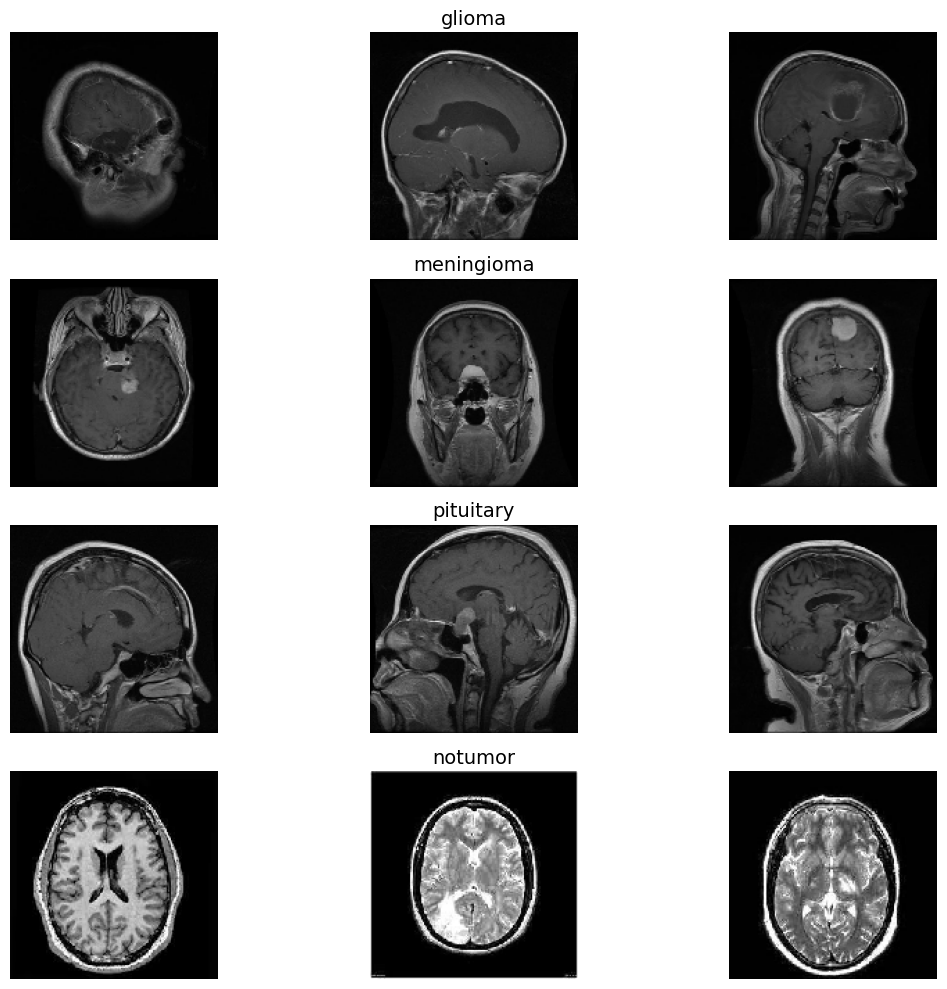

In [11]:
import os
import random
from tensorflow.keras.preprocessing import image

classes = ["glioma", "meningioma", "pituitary", "notumor"]

plt.figure(figsize=(12, 10))

for row, class_name in enumerate(classes):
    class_dir = os.path.join(train_path, class_name)
    images = os.listdir(class_dir)
    
   
    sample_images = random.sample(images, 3)
    
    for col, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = image.load_img(img_path, target_size=(150, 150))
        
        plt.subplot(len(classes), 3, row*3 + col + 1)
        plt.imshow(img)
        plt.axis("off")
        
        if col == 1:
            plt.title(class_name, fontsize=14)

plt.tight_layout()
plt.show()


## MRI Görsellerinin Sınıflara Göre İncelenmesi  

Her sınıftan örnek MRI görüntüleri incelendi. Burada amaç medikal teşhis yapmak değil, veri setindeki görsel farklılıkları yazılım açısından gözlemlemek ve modelin neyi öğrenmesi gerektiğini netleştirmektir.  

### 1. Glioma  
- Görsellerde beyin dokusu içinde yoğunluk farklılıkları ve düzensiz şekiller göze çarpıyor.  
- Bu sınıf, model için zorlayıcı olabilir çünkü sınırlar keskin değil; farklı bölgelerde farklı şekilde çıkabiliyor.  

### 2. Meningioma  
- Daha düzenli, kenara yakın ve net konturlara sahip yapılar göze çarpıyor.  
- Görseller model için daha “ayırt edilebilir” görünüyor, bu yüzden öğrenmesi görece kolay olabilir.  

### 3. Pituitary  
- Görsellerde beynin alt kısmına yakın küçük ve yoğun alanlar dikkat çekiyor.  
- Konum bilgisi burada kritik, çünkü diğer tümör tiplerinden farklı bir bölgede tekrarlanıyor. Bu da modele güçlü bir sinyal sağlar.  

### 4. No Tumor  
- Beyin dokusu homojen görünüyor, anormal parlaklık veya kitle yok.  
- Bu sınıfın doğru öğrenilmesi önemli, çünkü aksi durumda model yanlış alarm üretebilir (false positive).  

---

### Çıkarımlar  
- Veri setindeki sınıflar görsel açıdan gerçekten farklı ve bu farklar makine öğrenmesi açısından anlamlı özellikler taşıyor.  
- **Glioma** sınıfı en zor olan gibi görünüyor, çünkü farklı pozisyonlarda ve şekillerde çıkabiliyor.  
- **Meningioma** ve **Pituitary** daha konum odaklı ve düzenli sınıflar, modelin daha hızlı öğrenmesini sağlayabilir.  
- **No Tumor** sınıfı kritik çünkü yanlış sınıflandırma modelin güvenilirliğini ciddi şekilde düşürür.  


In [12]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

sample_img_path = os.path.join(train_path, "glioma", random.choice(os.listdir(os.path.join(train_path, "glioma"))))

img = load_img(sample_img_path, target_size=(150, 150))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

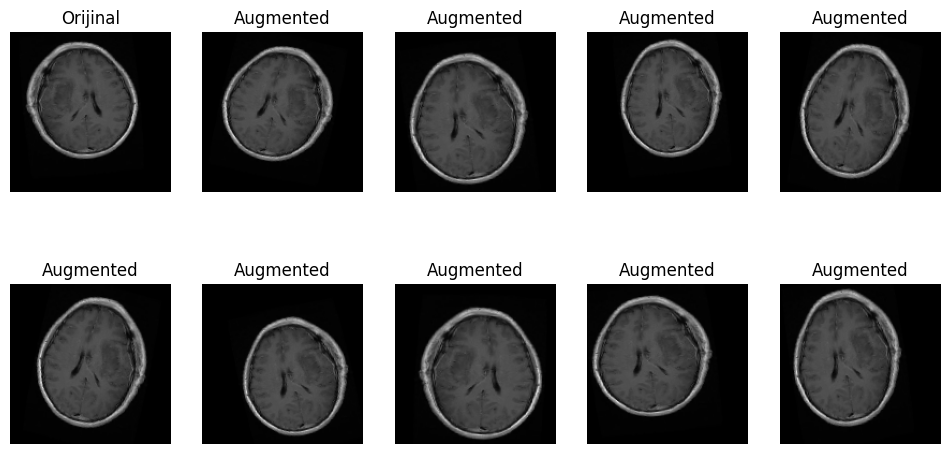

In [13]:
i = 1
plt.figure(figsize=(12, 6))

for batch in train_datagen.flow(img_array, batch_size=1):
    plt.subplot(2, 5, i)
    plt.imshow(batch[0])
    if i == 1:
        plt.title("Orijinal")
    else:
        plt.title("Augmented")
    plt.axis("off")
    i += 1
    if i > 10:
        break

plt.show()


### Veri Çoğaltma Örneği


Aşağıdaki görselde tek bir MRI görüntüsünün, **ImageDataGenerator** ile üretilmiş farklı versiyonları gösterilmektedir.  
- İlk kutucuk **orijinal resmi**, diğerleri ise **döndürme, kaydırma, yakınlaştırma ve yatay çevirme** gibi dönüşümler uygulanmış halini temsil etmektedir.  
- Bu sayede model yalnızca birebir aynı resmi değil, farklı açılardan ve konumlardan gelen varyasyonlarını da öğrenmektedir.  
- Böylelikle **overfitting riski azalır** ve model, gerçek hayatta karşılaşacağı çeşitli MRI görüntülerine karşı daha dayanıklı hale gelir.  

> Tek bir görüntüden onlarca farklı eğitim örneği elde ederek, sınırlı veri setinde bile güçlü bir model geliştirmek mümkün olur.


In [14]:
import warnings
warnings.filterwarnings("ignore")

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
#ilk katman
model.add(MaxPooling2D(pool_size=(2,2)))
#(3,3) Conv2D’de filtre boyutu, MaxPooling’de küçültme boyutu.


I0000 00:00:1758647259.586407      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758647259.587112      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


32 tane 3x3 filtre → basit kenar, çizgi gibi detayları öğreniyor.

ReLU → negatifleri sıfırlar, model daha iyi öğrenir.

MaxPooling → görüntüyü küçültür, ama önemli kısımları korur.

In [15]:
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


Bu defa 64 filtre → daha karmaşık desenleri öğreniyor.

In [16]:
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


Artık 128 filtre ile detaylı yapıları yakalıyor.

Yani “tümörün şekli, dokusu, nerede çıktığı” gibi farkları yakalayabilir.

In [17]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


Conv2D → convolution katmanı

MaxPooling2D → boyut küçültme

Flatten → 2D’den 1D’ye çevirme

Dense → tam bağlı (karar veren) katman

Dropout → overfitting’i engellemek için

In [18]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

###  CNN Model Mimarisinin Özeti

Modelimizde 3 adet **Conv2D (evrişimsel katman)** ve her birinin ardından gelen **MaxPooling2D (havuzlama katmanı)** bulunmaktadır. Son olarak **Flatten** katmanı ile veriler sınıflandırma için hazır hale getirilmiştir.  

- **Conv2D Katmanları** → Görsellerden farklı özellikleri (kenar, doku, şekil) öğrenir.  
- **MaxPooling Katmanları** → Görsellerin boyutunu küçülterek hesaplama maliyetini düşürür ve modelin daha genel öğrenmesini sağlar.  
- **Flatten Katmanı** → Çıkarılan özellik haritalarını tek boyutlu vektöre dönüştürür. Bu vektör, ileride ekleyeceğimiz **Dense katmanlarına** giriş olur.  

📊 **Parametreler**:  
- Toplam **93,248 öğrenilebilir parametre** vardır.  
- Parametrelerin tamamı eğitim sırasında güncellenir.  
- Model boyutu oldukça makul, bu sayede **GPU’da hızlı çalışır** ve **overfitting riski daha düşüktür**.  

Bu noktada modelimiz, görsellerden özellik çıkarma aşamasını tamamlamış olup, sınıflandırma için Dense katmanlarına hazırdır.


In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
import warnings
warnings.filterwarnings('ignore')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=1   
)

Epoch 1/20


I0000 00:00:1758647265.291531      85 service.cc:148] XLA service 0x7b678c004ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758647265.293040      85 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758647265.293061      85 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758647265.688812      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/143 ━━━━━━━━━━━━━━━━━━━━ 17:46 8s/step - accuracy: 0.2812 - loss: 1.3918

I0000 00:00:1758647269.959879      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 476ms/step - accuracy: 0.4693 - loss: 1.1063 - val_accuracy: 0.6819 - val_loss: 0.8527
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 247ms/step - accuracy: 0.7551 - loss: 0.6531 - val_accuracy: 0.7134 - val_loss: 0.7669
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - accuracy: 0.7769 - loss: 0.5713 - val_accuracy: 0.7607 - val_loss: 0.6604
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 236ms/step - accuracy: 0.8116 - loss: 0.4886 - val_accuracy: 0.7397 - val_loss: 0.7272
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 237ms/step - accuracy: 0.8126 - loss: 0.5156 - val_accuracy: 0.7055 - val_loss: 0.7523
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 236ms/step - accuracy: 0.8438 - loss: 0.4124 - val_accuracy: 0.7625 - val_loss: 0.6184
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step - accuracy: 0.8579 - loss: 0.3819 - val_accuracy: 0.7686 - val_loss: 0.5631
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 245ms/step - accuracy: 0.8498 - loss: 0.3899 - val

In [21]:
model.save("brain_tumor_model_final.h5")
print("Model başarıyla kaydedildi!")


Model başarıyla kaydedildi!


In [22]:
import pickle

with open("history_final.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("History başarıyla kaydedildi!")


History başarıyla kaydedildi!
